In [5]:
from dataset import Dataset
import numpy as np
import pandas as pd
import vectorbt as vbt
import pandas_ta as ta
import warnings
warnings.simplefilter(action='ignore')


In [4]:
data_binance = Dataset().get_data(days=360, ticker='BTCUSDT', ts='1h')


In [38]:
data = data_binance.copy()
candles = data.ta.cdl_pattern(name='all')
data = pd.concat([data, candles], axis=1)


In [40]:
target_names = []
fees = 0.001
for i in range(1, 13):
    name = f'expected_chg_{i}'
    target_names.append(name)
    data[name] = data['close'].pct_change(i).shift(-i)
    data[name] = data[name] - fees


In [61]:
candles.columns


Index(['CDL_2CROWS', 'CDL_3BLACKCROWS', 'CDL_3INSIDE', 'CDL_3LINESTRIKE',
       'CDL_3OUTSIDE', 'CDL_3STARSINSOUTH', 'CDL_3WHITESOLDIERS',
       'CDL_ABANDONEDBABY', 'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD',
       'CDL_BREAKAWAY', 'CDL_CLOSINGMARUBOZU', 'CDL_CONCEALBABYSWALL',
       'CDL_COUNTERATTACK', 'CDL_DARKCLOUDCOVER', 'CDL_DOJI_10_0.1',
       'CDL_DOJISTAR', 'CDL_DRAGONFLYDOJI', 'CDL_ENGULFING',
       'CDL_EVENINGDOJISTAR', 'CDL_EVENINGSTAR', 'CDL_GAPSIDESIDEWHITE',
       'CDL_GRAVESTONEDOJI', 'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI',
       'CDL_HARAMICROSS', 'CDL_HIGHWAVE', 'CDL_HIKKAKE', 'CDL_HIKKAKEMOD',
       'CDL_HOMINGPIGEON', 'CDL_IDENTICAL3CROWS', 'CDL_INNECK', 'CDL_INSIDE',
       'CDL_INVERTEDHAMMER', 'CDL_KICKING', 'CDL_KICKINGBYLENGTH',
       'CDL_LADDERBOTTOM', 'CDL_LONGLEGGEDDOJI', 'CDL_LONGLINE',
       'CDL_MARUBOZU', 'CDL_MATCHINGLOW', 'CDL_MATHOLD', 'CDL_MORNINGDOJISTAR',
       'CDL_MORNINGSTAR', 'CDL_ONNECK', 'CDL_PIERCING', 'CDL_RICKSHAWMAN',
       

In [49]:
data.groupby(['CDL_HAMMER'])['expected_chg_5']\
    .agg(['sum', 'mean'])


sum      mean
CDL_HAMMER                    
0.0        -7.279702 -0.000861
100.0       0.108418  0.000599

<AxesSubplot:xlabel='time'>

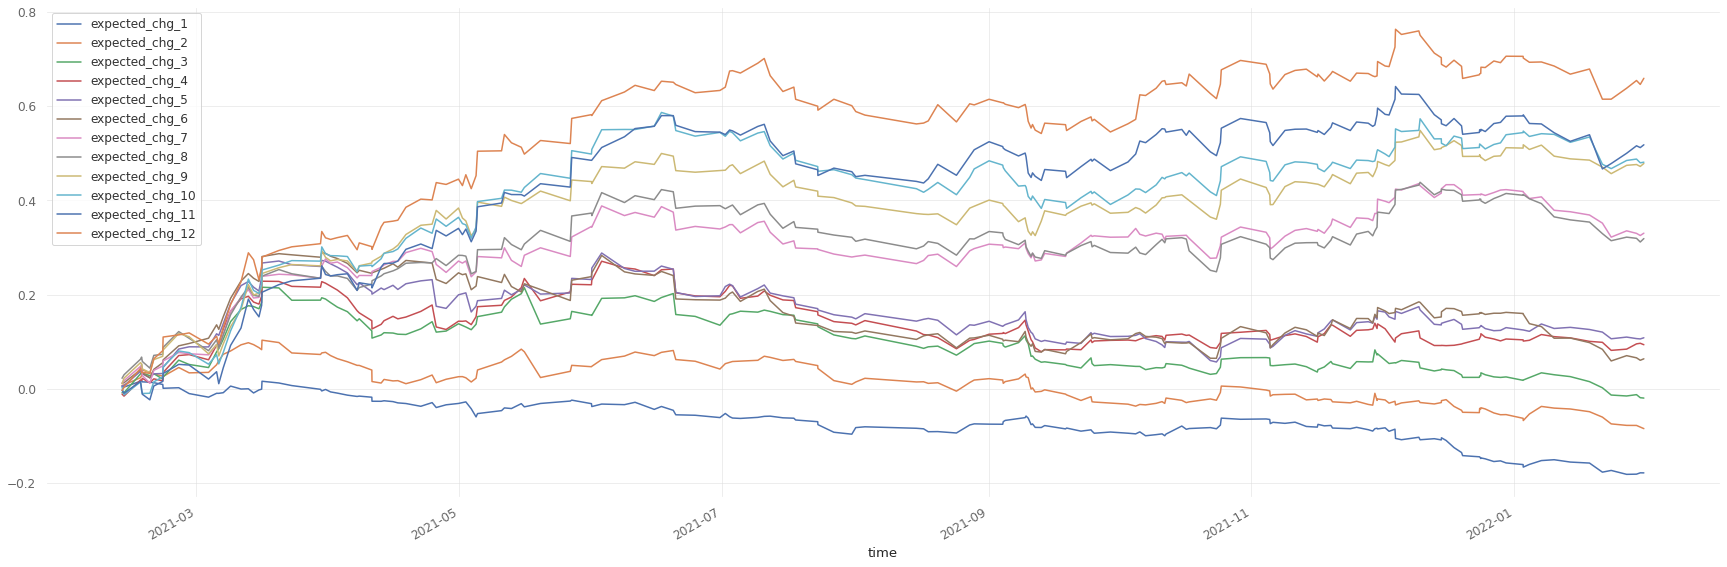

In [51]:
data[data['CDL_HAMMER'] != 0][target_names].cumsum().plot(figsize=(30, 10))


In [54]:
data['entries_long'] = np.where(data['CDL_HAMMER'] == 100, True, False)
data['exits_long'] = np.where(
    data['entries_long'].shift(12) == True, True, False)
pf = vbt.Portfolio.from_signals(
    data['close'],
    data['entries_long'],
    data['exits_long'],
    fees=0.001
)
pf.plot().show()


In [55]:
pf.stats()


Start                         2021-02-06 01:00:00
End                           2022-02-01 18:00:00
Period                                       8645
Start Value                                 100.0
End Value                              145.268136
Total Return [%]                        45.268136
Benchmark Return [%]                     0.016778
Max Gross Exposure [%]                      100.0
Total Fees Paid                         41.339993
Max Drawdown [%]                        16.972695
Max Drawdown Duration                      2453.0
Total Trades                                  144
Total Closed Trades                           144
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            52.083333
Best Trade [%]                           6.052096
Worst Trade [%]                         -6.499568
Avg Winning Trade [%]                    1.792504
Avg Losing Trade [%]                    -1.362481


In [56]:
stop_loss = np.arange(0.005, 0.055, 0.005)
take_profit = np.arange(0.005, 0.055, 0.005)
tr_stop = np.arange(0.001, 0.01, 0.001)
results = []
data['entries_long'] = np.where(data['CDL_HAMMER'] == 100, True, False)
data['exits_long'] = np.where(data['entries_long'].shift(12), True, False)

for stop in stop_loss:
    for take in take_profit:
        for tr in tr_stop:
            pf = vbt.Portfolio.from_signals(
                data['close'],
                data['entries_long'],
                data['exits_long'],
                fees=0.001,
                sl_stop=stop,
                tp_stop=take,
                sl_trail=tr
            )
            results.append({
                'stop_loss': stop,
                'take_profit': take,
                'trail': tr,
                'stat': pf.returns_stats()
            })


In [57]:
best = [i for i in results if i.get('stat')['Total Return [%]'] > 30]


In [58]:
best


[{'stop_loss': 0.045,
  'take_profit': 0.02,
  'trail': 0.001,
  'stat': Start                    2021-02-06 01:00:00
  End                      2022-02-01 18:00:00
  Period                                  8645
  Total Return [%]                   32.367494
  Benchmark Return [%]                0.016778
  Max Drawdown [%]                   14.907208
  Max Drawdown Duration                 2716.0
  Skew                               -1.330161
  Kurtosis                           52.271704
  Tail Ratio                          1.256278
  Value at Risk                      -0.002606
  Beta                                0.124269
  dtype: object},
 {'stop_loss': 0.045,
  'take_profit': 0.02,
  'trail': 0.002,
  'stat': Start                    2021-02-06 01:00:00
  End                      2022-02-01 18:00:00
  Period                                  8645
  Total Return [%]                   32.367494
  Benchmark Return [%]                0.016778
  Max Drawdown [%]                   14.9

In [59]:
data['entries_long'] = np.where(data['CDL_HAMMER'] == 100, True, False)
data['exits_long'] = np.where(
    data['entries_long'].shift(12) == True, True, False)
pf = vbt.Portfolio.from_signals(
    data['close'],
    data['entries_long'],
    data['exits_long'],
    fees=0.001,
    sl_stop=0.05,
    tp_stop=0.02,
    sl_trail=0.007
)
pf.plot().show()


In [60]:
pf.stats()


Start                         2021-02-06 01:00:00
End                           2022-02-01 18:00:00
Period                                       8645
Start Value                                 100.0
End Value                              138.415508
Total Return [%]                        38.415508
Benchmark Return [%]                     0.016778
Max Gross Exposure [%]                      100.0
Total Fees Paid                         40.360884
Max Drawdown [%]                        14.907208
Max Drawdown Duration                      2181.0
Total Trades                                  150
Total Closed Trades                           150
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            53.333333
Best Trade [%]                           4.327665
Worst Trade [%]                         -5.891099
Avg Winning Trade [%]                    1.729358
Avg Losing Trade [%]                    -1.468269
